## (a) import packages

In [53]:
import os
import random
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16

## (b) Data Exploration and Pre-processing

In [54]:
split_dict = {'train':[], 'test':[], 'val':[]}

for split in split_dict:
    with open('data_split/' + split + '_source_images.txt', 'r') as file:
        subframes = file.readlines()
        for subframe in subframes:
            split_dict[split].append(subframe.strip())


train_data, test_data, val_data = [], [], []

for dir in os.scandir('data'):
    if os.path.isdir(dir):
        temp_data = []
        for label in os.listdir(dir.path + '/tiles'):
            if os.path.isdir(dir.path + '/tiles/' + label):
                for image in os.scandir(dir.path + '/tiles/' + label):
                    temp_data.append((image.path, label))
                    
            if dir.path.split('/')[2][:15] in split_dict['train']:
                train_data.extend(temp_data)
            elif dir.path.split('/')[2][:15] in split_dict['test']:
                test_data.extend(temp_data)
            elif dir.path.split('/')[2][:15] in split_dict['val']:
                val_data.extend(temp_data)

In [55]:
def load_and_preprocess(img_loc, label):    
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        return img, 1 if label_str=='frost' else 0
        
    x, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    x.set_shape([299, 299, 3])
    y.set_shape([])
    return x, y

In [56]:
buffer_size = 64
batch_size = 32

random.shuffle(test_data)
img_list, label_list = zip(*test_data)
img_list = tf.convert_to_tensor(img_list)
label_list = tf.convert_to_tensor(label_list)
test_tf = tf.data.Dataset.from_tensor_slices((img_list, label_list))
test_tf = test_tf.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_tf = test_tf.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(val_data)
img_list, label_list = zip(*val_data)
img_list = tf.convert_to_tensor(img_list)
label_list = tf.convert_to_tensor(label_list)
val_tf = tf.data.Dataset.from_tensor_slices((img_list, label_list))
val_tf = val_tf.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_tf = val_tf.shuffle(buffer_size=buffer_size).batch(batch_size)

## (c) Training CNN + MLP

### (i) Data Augmentation

In [57]:
def data_augmentation(img_loc, label):
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        image = Image.open(img_loc_str).convert('RGB')
        
        image = tf.image.random_crop(image, size = [299, 299, 3])

        scale_factor = random.uniform(0.8, 1.2)
        zoomed_shape = tf.cast(299 * scale_factor, tf.int32)
        image = tf.image.resize(image, size = [zoomed_shape, zoomed_shape])
    
        image = tf.image.rot90(image, k = random.randint(0, 4))
    
        image = tf.image.random_flip_left_right(image)
    
        image = tf.image.random_contrast(image, lower = 0.5, upper = 1.5)
        
        image = tf.image.resize(image, size = [299, 299])
        
        return image, 1 if label_str=='frost' else 0
        
    x, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    x.set_shape([299, 299, 3])
    y.set_shape([])
    
    return x,y

In [58]:
random.shuffle(train_data)
img_list, label_list = zip(*train_data)
img_list = tf.convert_to_tensor(img_list)
label_list = tf.convert_to_tensor(label_list)
train_tf = tf.data.Dataset.from_tensor_slices((img_list, label_list))
train_tf = train_tf.map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_tf = train_tf.shuffle(buffer_size=buffer_size).batch(batch_size)

### (ii) Training 

In [61]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(299, 299, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', start_from_epoch=20, patience=5, restore_best_weights=True)

In [62]:
cnn = model.fit(train_tf, epochs = 30, batch_size = 32, validation_data = val_tf, callbacks = [early_stopping])

Epoch 1/30


2023-12-08 22:39:36.785283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [29679]
	 [[{{node Placeholder/_0}}]]
2023-12-08 22:39:36.785823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [29679]
	 [[{{node Placeholder/_1}}]]


928/928 [==============================] - ETA: 0s - loss: 2.2922 - accuracy: 0.6663

2023-12-08 23:10:53.711701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [11286]
	 [[{{node Placeholder/_0}}]]
2023-12-08 23:10:53.712376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [11286]
	 [[{{node Placeholder/_1}}]]


928/928 [==============================] - 2033s 2s/step - loss: 2.2922 - accuracy: 0.6663 - val_loss: 1.2533 - val_accuracy: 0.8455
Epoch 2/30
928/928 [==============================] - 1872s 2s/step - loss: 1.3911 - accuracy: 0.7407 - val_loss: 2.7432 - val_accuracy: 0.3272
Epoch 3/30
928/928 [==============================] - 1657s 2s/step - loss: 1.5752 - accuracy: 0.7661 - val_loss: 2.3347 - val_accuracy: 0.8526
Epoch 4/30
928/928 [==============================] - 1676s 2s/step - loss: 1.6238 - accuracy: 0.7834 - val_loss: 2.3404 - val_accuracy: 0.6722
Epoch 5/30
928/928 [==============================] - 1745s 2s/step - loss: 1.7962 - accuracy: 0.7891 - val_loss: 3.6632 - val_accuracy: 0.3254
Epoch 6/30
928/928 [==============================] - 1674s 2s/step - loss: 1.8672 - accuracy: 0.7995 - val_loss: 6.9820 - val_accuracy: 0.3218
Epoch 7/30
928/928 [==============================] - 1717s 2s/step - loss: 1.9562 - accuracy: 0.8047 - val_loss: 2.3590 - val_accuracy: 0.5152
Epo

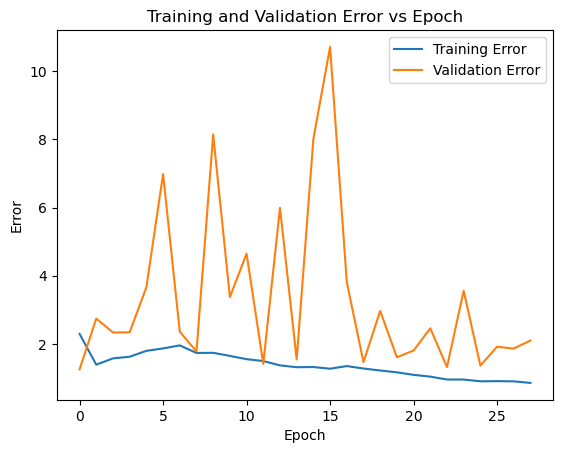

In [63]:
plt.plot(cnn.history['loss'], label='Training Error')
plt.plot(cnn.history['val_loss'], label='Validation Error')
plt.title('Training and Validation Error vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

### (iii) Evaluation

In [64]:
y_true, y_pred = [], []
for x, y in tqdm(test_tf):
    y_true.append(y.numpy())
    y_pred.append(np.argmax(model.predict(x, verbose=0), axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1 Score:', round(f1, 4))

  0%|                                                   | 0/401 [00:00<?, ?it/s]2023-12-09 12:40:22.843492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [12823]
	 [[{{node Placeholder/_1}}]]
2023-12-09 12:40:22.843976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [12823]
	 [[{{node Placeholder/_1}}]]
100%|█████████████████████████████████████████| 401/401 [02:38<00:00,  2.53it/s]

Accuracy: 0.7386
Precision: 0.8497
Recall: 0.7304
F1 Score: 0.7855


## (d) Transfer Learning

### (i) & (ii) already performed in (c)

### (iii) Model Architecture

In [70]:
def transfer_learning(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation = 'relu' , kernel_regularizer = l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation = 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)

    return model

### (iv) & (v) Training and Evaluation

### EfficientNetB0

In [71]:
efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in efficientnetb0.layers:
    layer.trainable = False

efficientnetb0_transfer = transfer_learning(efficientnetb0)

efficientnetb0_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', start_from_epoch=10, patience=5, restore_best_weights=True)

In [72]:
efficientnet = efficientnetb0_transfer.fit(train_tf, epochs=12, validation_data=val_tf, callbacks=[early_stopping])

Epoch 1/12
928/928 [==============================] - 963s 1s/step - loss: 0.8512 - accuracy: 0.8906 - val_loss: 2.3176 - val_accuracy: 0.4877
Epoch 2/12
928/928 [==============================] - 976s 1s/step - loss: 0.3422 - accuracy: 0.9002 - val_loss: 2.1268 - val_accuracy: 0.5017
Epoch 3/12
928/928 [==============================] - 983s 1s/step - loss: 0.2993 - accuracy: 0.9080 - val_loss: 0.7468 - val_accuracy: 0.7447
Epoch 4/12
928/928 [==============================] - 994s 1s/step - loss: 0.2796 - accuracy: 0.9111 - val_loss: 0.7061 - val_accuracy: 0.7964
Epoch 5/12
928/928 [==============================] - 994s 1s/step - loss: 0.2733 - accuracy: 0.9142 - val_loss: 0.7522 - val_accuracy: 0.8031
Epoch 6/12
928/928 [==============================] - 993s 1s/step - loss: 0.2676 - accuracy: 0.9131 - val_loss: 1.9949 - val_accuracy: 0.4971
Epoch 7/12
928/928 [==============================] - 996s 1s/step - loss: 0.2867 - accuracy: 0.9100 - val_loss: 1.1145 - val_accuracy: 0.6702

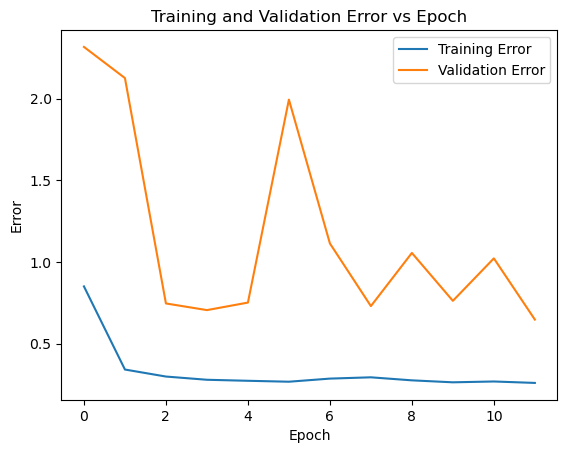

In [73]:
plt.plot(efficientnet.history['loss'], label='Training Error')
plt.plot(efficientnet.history['val_loss'], label='Validation Error')
plt.title('Training and Validation Error vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [74]:
y_true, y_pred = [], []
for x, y in tqdm(test_tf):
    y_true.append(y.numpy())
    y_pred.append(np.argmax(efficientnetb0_transfer.predict(x, verbose=0), axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1 Score:', round(f1, 4))

100%|█████████████████████████████████████████| 401/401 [05:28<00:00,  1.22it/s]

Accuracy: 0.9292
Precision: 0.9159
Recall: 0.9822
F1 Score: 0.9479


### ResNet50

In [75]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in resnet50.layers:
    layer.trainable = False

resnet50_transfer = transfer_learning(resnet50)

resnet50_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', start_from_epoch=10, patience=5, restore_best_weights=True)

In [76]:
resnet = resnet50_transfer.fit(train_tf, epochs=12, validation_data=val_tf, callbacks=[early_stopping])

Epoch 1/12
928/928 [==============================] - 2846s 3s/step - loss: 0.6561 - accuracy: 0.9009 - val_loss: 0.8312 - val_accuracy: 0.7751
Epoch 2/12
928/928 [==============================] - 2878s 3s/step - loss: 0.3101 - accuracy: 0.9139 - val_loss: 0.5530 - val_accuracy: 0.8550
Epoch 3/12
928/928 [==============================] - 3086s 3s/step - loss: 0.2843 - accuracy: 0.9152 - val_loss: 1.0095 - val_accuracy: 0.6758
Epoch 4/12
928/928 [==============================] - 3132s 3s/step - loss: 0.2694 - accuracy: 0.9188 - val_loss: 0.8604 - val_accuracy: 0.7495
Epoch 5/12
928/928 [==============================] - 3136s 3s/step - loss: 0.2622 - accuracy: 0.9194 - val_loss: 0.7597 - val_accuracy: 0.7740
Epoch 6/12
928/928 [==============================] - 3156s 3s/step - loss: 0.2573 - accuracy: 0.9188 - val_loss: 0.5261 - val_accuracy: 0.8604
Epoch 7/12
928/928 [==============================] - 3134s 3s/step - loss: 0.2488 - accuracy: 0.9196 - val_loss: 0.7839 - val_accuracy:

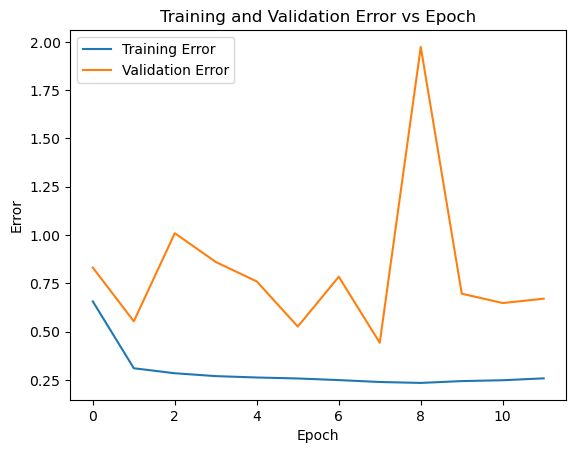

In [77]:
plt.plot(resnet.history['loss'], label='Training Error')
plt.plot(resnet.history['val_loss'], label='Validation Error')
plt.title('Training and Validation Error vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [78]:
y_true, y_pred = [], []
for x, y in tqdm(test_tf):
    y_true.append(y.numpy())
    y_pred.append(np.argmax(resnet50_transfer.predict(x, verbose=0), axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1 Score:', round(f1, 4))

100%|█████████████████████████████████████████| 401/401 [14:01<00:00,  2.10s/it]

Accuracy: 0.9385
Precision: 0.9238
Recall: 0.9876
F1 Score: 0.9546


### VGG16

In [79]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in vgg16.layers:
    layer.trainable = False

vgg16_transfer = transfer_learning(vgg16)

vgg16_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', start_from_epoch=10, patience=5, restore_best_weights=True)

In [81]:
vgg = vgg16_transfer.fit(train_tf, epochs=10, validation_data=val_tf, callbacks=[early_stopping])

Epoch 1/10
928/928 [==============================] - 8793s 9s/step - loss: 0.6649 - accuracy: 0.8976 - val_loss: 0.8259 - val_accuracy: 0.7088
Epoch 2/10
928/928 [==============================] - 8994s 10s/step - loss: 0.3247 - accuracy: 0.9191 - val_loss: 0.7401 - val_accuracy: 0.7597
Epoch 3/10
928/928 [==============================] - 9276s 10s/step - loss: 0.3050 - accuracy: 0.9171 - val_loss: 0.8397 - val_accuracy: 0.6746
Epoch 4/10
928/928 [==============================] - 9901s 11s/step - loss: 0.2917 - accuracy: 0.9165 - val_loss: 0.8648 - val_accuracy: 0.6722
Epoch 5/10
928/928 [==============================] - 9352s 10s/step - loss: 0.2762 - accuracy: 0.9212 - val_loss: 0.6016 - val_accuracy: 0.7851
Epoch 6/10
928/928 [==============================] - 8827s 10s/step - loss: 0.2724 - accuracy: 0.9218 - val_loss: 0.7165 - val_accuracy: 0.7454
Epoch 7/10
928/928 [==============================] - 8802s 9s/step - loss: 0.2692 - accuracy: 0.9213 - val_loss: 0.5875 - val_accu

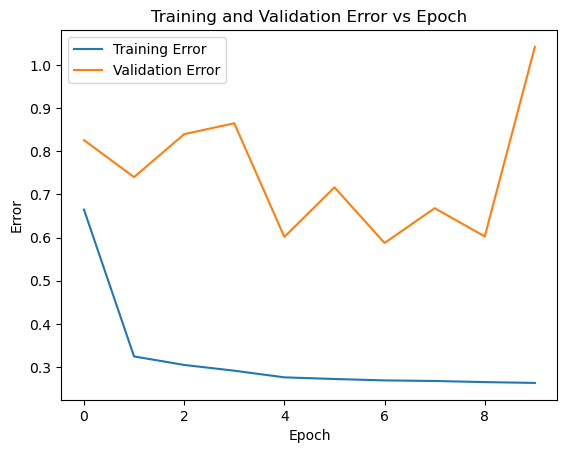

In [82]:
plt.plot(vgg.history['loss'], label='Training Error')
plt.plot(vgg.history['val_loss'], label='Validation Error')
plt.title('Training and Validation Error vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [83]:
y_true, y_pred = [], []
for x, y in tqdm(test_tf):
    y_true.append(y.numpy())
    y_pred.append(np.argmax(vgg16_transfer.predict(x, verbose=0), axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('Accuracy:', round(accuracy, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))
print('F1 Score:', round(f1, 4))

100%|█████████████████████████████████████████| 401/401 [43:56<00:00,  6.57s/it]

Accuracy: 0.8412
Precision: 0.8101
Recall: 0.9898
F1 Score: 0.891


### (vi) Comparison

All the evaluation metrics accuracy, precision, recall and f1 score are better in transfer learning than that of CNN+MLP.<br>
Even though transfer learning is trained with less epochs, it still gives us better results because of the previous knowledge it has.<br>
Although training time/epoch for these methods vary drastically, it is efficientnet, cnn+mlp, resnet and vgg in ascending order.<br>
Overall Resnet50 is giving us best results.